
--- Fold 1 ---


d:\AllProjects\tool_proj\tool-tracking\tool-tracking_env\Lib\site-packages\torch\nn\utils\weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Epoch 1: Train Loss = 0.8327, Val Loss = 0.4160
Train Acc = 0.5625, Val Acc = 0.7536
Epoch 2: Train Loss = 0.3315, Val Loss = 0.6414
Train Acc = 0.8116, Val Acc = 0.5571
Epoch 3: Train Loss = 0.2260, Val Loss = 0.5705
Train Acc = 0.8723, Val Acc = 0.5429
Epoch 4: Train Loss = 0.1811, Val Loss = 0.2879
Train Acc = 0.8839, Val Acc = 0.8321
Epoch 5: Train Loss = 0.1581, Val Loss = 0.2352
Train Acc = 0.8991, Val Acc = 0.8500
Epoch 6: Train Loss = 0.1379, Val Loss = 0.2180
Train Acc = 0.9045, Val Acc = 0.8179
Epoch 7: Train Loss = 0.1309, Val Loss = 0.1743
Train Acc = 0.8938, Val Acc = 0.8714
Epoch 8: Train Loss = 0.1100, Val Loss = 0.4091
Train Acc = 0.9161, Val Acc = 0.7357
Epoch 9: Train Loss = 0.1072, Val Loss = 0.0844
Train Acc = 0.9116, Val Acc = 0.9286
Epoch 10: Train Loss = 0.0937, Val Loss = 0.3370
Train Acc = 0.9214, Val Acc = 0.8000
Epoch 11: Train Loss = 0.0947, Val Loss = 0.1192
Train Acc = 0.9161, Val Acc = 0.8964
Epoch 12: Train Loss = 0.0812, Val Loss = 0.1459
Train Acc = 0.

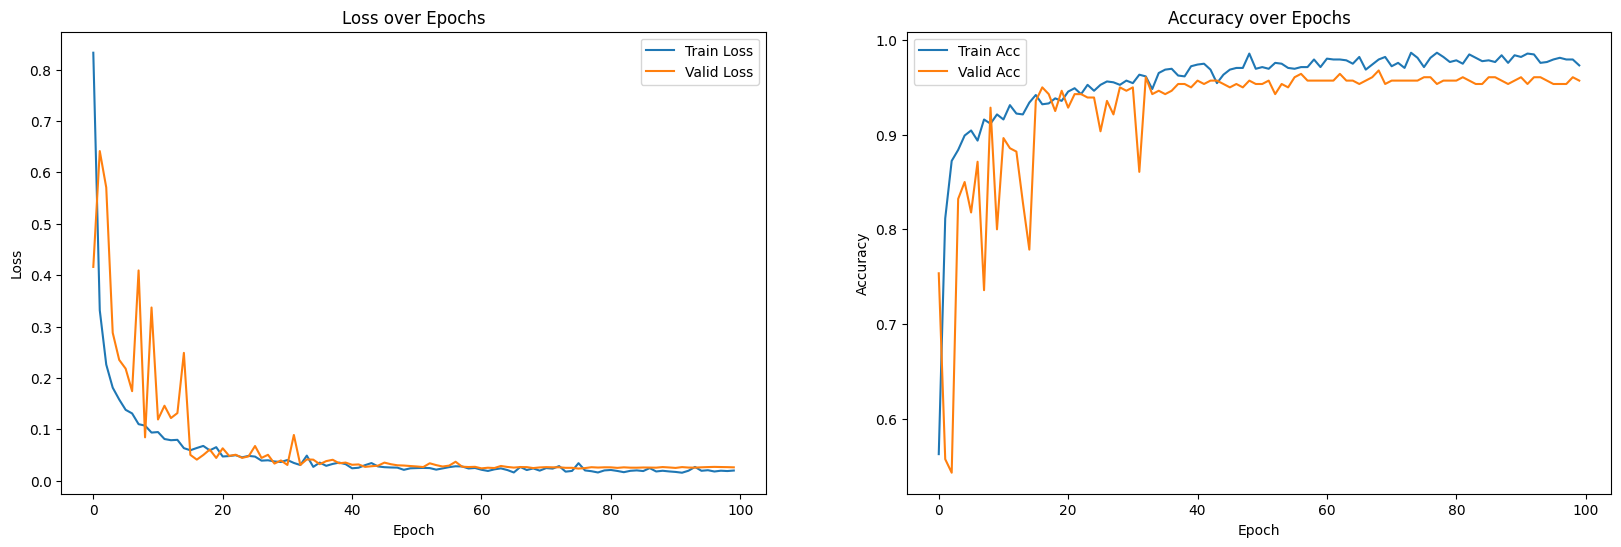


Fold 1 Accuracy: 0.9571
Fold 1 Weighted F1 Score: 0.9535
                       precision    recall  f1-score   support

           tightening       0.94      0.97      0.95       128
         untightening       1.00      1.00      1.00        55
    motor_activity_cw       0.91      0.88      0.90        49
   motor_activity_ccw       1.00      1.00      1.00        21
manual_motor_rotation       1.00      1.00      1.00        11
              shaking       1.00      1.00      1.00        14
    tightening_double       0.00      0.00      0.00         2

             accuracy                           0.96       280
            macro avg       0.84      0.84      0.84       280
         weighted avg       0.95      0.96      0.95       280



d:\AllProjects\tool_proj\tool-tracking\tool-tracking_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\AllProjects\tool_proj\tool-tracking\tool-tracking_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\AllProjects\tool_proj\tool-tracking\tool-tracking_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

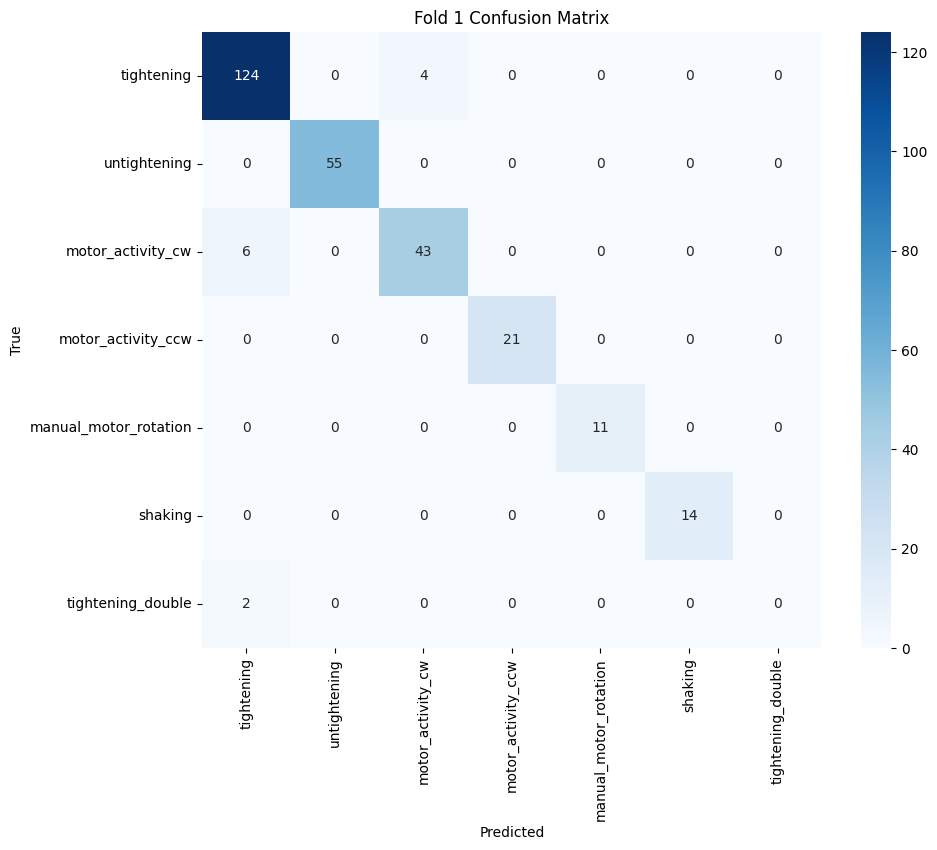

Model successfully saved to ./trained_model/tcn_model0_electric_screwdriver.pth.

--- Fold 2 ---


d:\AllProjects\tool_proj\tool-tracking\tool-tracking_env\Lib\site-packages\torch\nn\utils\weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Epoch 1: Train Loss = 0.7147, Val Loss = 0.4765
Train Acc = 0.5679, Val Acc = 0.7000
Epoch 2: Train Loss = 0.3178, Val Loss = 0.3903
Train Acc = 0.7902, Val Acc = 0.7000
Epoch 3: Train Loss = 0.2252, Val Loss = 0.3630
Train Acc = 0.8357, Val Acc = 0.7536
Epoch 4: Train Loss = 0.1742, Val Loss = 0.3572
Train Acc = 0.8786, Val Acc = 0.8071
Epoch 5: Train Loss = 0.1510, Val Loss = 0.1127
Train Acc = 0.8866, Val Acc = 0.9143
Epoch 6: Train Loss = 0.1188, Val Loss = 0.2414
Train Acc = 0.9098, Val Acc = 0.7036
Epoch 7: Train Loss = 0.1296, Val Loss = 0.1115
Train Acc = 0.8911, Val Acc = 0.9250
Epoch 8: Train Loss = 0.1089, Val Loss = 0.3481
Train Acc = 0.9062, Val Acc = 0.7429
Epoch 9: Train Loss = 0.0951, Val Loss = 0.1029
Train Acc = 0.9170, Val Acc = 0.9357
Epoch 10: Train Loss = 0.0908, Val Loss = 0.5069
Train Acc = 0.9170, Val Acc = 0.7179
Epoch 11: Train Loss = 0.0954, Val Loss = 1.1931
Train Acc = 0.9018, Val Acc = 0.6179
Epoch 12: Train Loss = 0.0851, Val Loss = 0.2366
Train Acc = 0.

KeyboardInterrupt: 

In [ ]:
import numpy as np
import random
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils import weight_norm
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import csv
import seaborn as sns
import torch.nn.functional as F

# Set random seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

# Load the train data
mytool = "electric_screwdriver"  # or "pneumatic_screwdriver"
output_dir = "./processed_data/"
combined_data = np.load(os.path.join(output_dir, f"combined_data_train_{mytool}.npy"))
combined_labels = np.load(os.path.join(output_dir, f"combined_label_train_{mytool}.npy"))

# Label information
if mytool == "electric_screwdriver":
    label_info = {
        2: 'tightening',
        3: 'untightening',
        4: 'motor_activity_cw',
        5: 'motor_activity_ccw',
        6: 'manual_motor_rotation',
        7: 'shaking',
        14: 'tightening_double'
    }
elif mytool == "pneumatic_screwdriver":
    label_info = {
        2: 'tightening',
        3: 'untightening',
        4: 'motor_activity_cw',
        5: 'motor_activity_ccw',
        7: 'shaking',
        14: 'tightening_double',
        38: 'impact'
    }

valid_labels = list(label_info.keys())

# Prepare data
X = combined_data
y = combined_labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
X_tensor = torch.FloatTensor(X)
y_tensor = torch.LongTensor(y_encoded)

# Enhanced TCN Model Implementation
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()

class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                         stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.bn1 = nn.BatchNorm1d(n_outputs)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        
        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                         stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.bn2 = nn.BatchNorm1d(n_outputs)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        
        self.net = nn.Sequential(self.conv1, self.chomp1, self.bn1, self.relu1, self.dropout1,
                               self.conv2, self.chomp2, self.bn2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size=3, dropout=0.2):
        super(TCN, self).__init__()
        layers = []
        num_levels = len(num_channels)
        max_dilation = 8  # Cap dilation to prevent excessive padding
        
        for i in range(num_levels):
            dilation = min(2 ** i, max_dilation)
            in_channels = input_size if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, 
                                   stride=1, dilation=dilation,
                                   padding=(kernel_size-1) * dilation, 
                                   dropout=dropout)]
        
        self.network = nn.Sequential(*layers)
        self.fc1 = nn.Linear(num_channels[-1], num_channels[-1]//2)
        self.bn_fc = nn.BatchNorm1d(num_channels[-1]//2)
        self.dropout_fc = nn.Dropout(dropout)
        self.fc2 = nn.Linear(num_channels[-1]//2, output_size)
        
        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.network(x)
        x = x[:, :, -1]
        x = self.fc1(x)
        x = self.bn_fc(x)
        x = F.relu(x)
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x

class SimpleFocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None):
        super(SimpleFocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = torch.tensor(alpha, dtype=torch.float32) if alpha is not None else None

    def forward(self, inputs, targets):
        device = inputs.device
        log_probs = F.log_softmax(inputs, dim=1)
        probs = log_probs.exp()
        log_probs_true = log_probs.gather(1, targets.view(-1, 1)).squeeze(1)
        probs_true = probs.gather(1, targets.view(-1, 1)).squeeze(1).clamp(min=1e-9)
        if self.alpha is not None:
            alpha_t = self.alpha.to(device)[targets]
            loss = -alpha_t * (1 - probs_true)**self.gamma * log_probs_true
        else:
            loss = - (1 - probs_true)**self.gamma * log_probs_true
        return loss.mean()

# Training Configuration
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = X.shape[2]
output_dim = len(label_info)
num_channels = [128, 128, 128, 64]  # Deeper and wider architecture
batch_size = 32
num_epochs = 100

# K-Fold Training Loop
fold_accuracies, fold_f1s = [], []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_tensor, y_tensor)):
    print(f"\n--- Fold {fold+1} ---")

    X_train, X_val = X_tensor[train_idx], X_tensor[val_idx]
    y_train, y_val = y_tensor[train_idx], y_tensor[val_idx]

    # Weighted Sampling for class imbalance
    class_sample_counts = np.array([(y_train == t).sum() for t in torch.unique(y_train)])
    weights = 1. / class_sample_counts
    samples_weight = np.array([weights[t] for t in y_train.numpy()])
    samples_weight = torch.from_numpy(samples_weight).float()
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
    if mytool == "pneumatic_screwdriver":
        train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, sampler=sampler)
    val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)

    model = TCN(input_size=input_dim, output_size=output_dim, num_channels=num_channels).to(device)
    criterion = SimpleFocalLoss(gamma=2.0)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

    train_losses, valid_losses = [], []
    train_accuracies, valid_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct / total)

        model.eval()
        valid_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
        valid_losses.append(valid_loss / len(val_loader))
        valid_accuracies.append(correct / total)
        scheduler.step(valid_losses[-1])
        
        print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]:.4f}, Val Loss = {valid_losses[-1]:.4f}")
        print(f"Train Acc = {train_accuracies[-1]:.4f}, Val Acc = {valid_accuracies[-1]:.4f}")

    # Final Evaluation on Validation Set
    y_true, y_pred = [], []
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(predicted.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    fold_accuracies.append(acc)
    fold_f1s.append(f1)

    # Plot training curves
    plt.figure(figsize=(20, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(valid_losses, label='Valid Loss')
    plt.legend()
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Acc')
    plt.plot(valid_accuracies, label='Valid Acc')
    plt.legend()
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

    print(f"\nFold {fold+1} Accuracy: {acc:.4f}")
    print(f"Fold {fold+1} Weighted F1 Score: {f1:.4f}")
    print(classification_report(y_true, y_pred, target_names=[label_info[i] for i in valid_labels]))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_info.values(), yticklabels=label_info.values())
    plt.title(f'Fold {fold+1} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Save model
    model_dir = "./trained_model/"
    os.makedirs(model_dir, exist_ok=True)
    model_file = os.path.join(model_dir, f"tcn_model{fold}_{mytool}.pth")
    torch.save(model.state_dict(), model_file)
    print(f"Model successfully saved to {model_file}.")

# Overall Summary
print(f"\nAverage Accuracy over {n_splits} folds: {np.mean(fold_accuracies):.4f}")
print(f"Average Weighted F1 Score over {n_splits} folds: {np.mean(fold_f1s):.4f}")

# Test Evaluation
num_of_classes = len(label_info)
split_count = 4  # Which fold's model to use for testing
loaded_model = TCN(input_size=X.shape[2], output_size=num_of_classes, num_channels=num_channels)
loaded_model.to(device)

model_file = os.path.join(model_dir, f"tcn_model{split_count}_{mytool}.pth")
loaded_model.load_state_dict(torch.load(model_file, map_location=device))
loaded_model.eval()
print("Model successfully loaded.")

# Load test data
combined_data_test = np.load(os.path.join(output_dir, f"combined_data_test_{mytool}.npy"))
combined_labels_test = np.load(os.path.join(output_dir, f"combined_label_test_{mytool}.npy"))

X_test = combined_data_test
y_test = combined_labels_test
y_test_encoded = label_encoder.transform(y_test)
X_tensor_test = torch.FloatTensor(X_test)
y_tensor_test = torch.LongTensor(y_test_encoded)

test_loader = DataLoader(TensorDataset(X_tensor_test, y_tensor_test), batch_size=batch_size, shuffle=False)

# Test evaluation
loaded_model.eval()
predicted_labels = []
true_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = loaded_model(inputs)
        preds = outputs.argmax(1)
        predicted_labels.extend(preds.cpu().numpy()) 
        true_labels.extend(labels.numpy()) 

accuracy = accuracy_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels, average='weighted')
print(f"\nTest Accuracy: {accuracy:.4f}")
print(f"Test Weighted F1 Score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
class_names = [label_info[i] for i in valid_labels]
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Test Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

# Save results
results_file = "results.csv"
tool_type = mytool
header = ['tool_type', 'split_count', 'accuracy', 'f1']
file_exists = os.path.exists(results_file)

with open(results_file, mode='a', newline='') as csvfile:
    writer = csv.writer(csvfile)
    if not file_exists:
        writer.writerow(header)
    writer.writerow([tool_type, split_count, round(accuracy * 100, 2), round(f1 * 100, 2)])

print(f"Results successfully recorded in {results_file}.")